In [1]:
from numpy.core.fromnumeric import shape
%reset

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import importlib
import PA_model
importlib.reload(PA_model)
import sionna as sn
from sionna.phy.mapping import Constellation
from PA_model import PAModel

In [3]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))


1


In [4]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras import layers, Model

In [5]:

class Modulator(Layer):

    def __init__(self, constellation, **kwargs):
        super(Modulator,self).__init__(**kwargs)

        # Define the real and imaginary parts of the constellation as trainable variables
        self.constellation_real = tf.Variable(constellation.real, dtype=tf.float32, trainable=True)
        self.constellation_imag = tf.Variable(constellation.imag, dtype=tf.float32, trainable=True)

    def call(self, s):
        # Combine the real and imaginary parts into a complex-valued constellation
        constellation_combined = tf.complex(self.constellation_real, self.constellation_imag)

        # Expand the signal dimension to align for matrix multiplication
        s = tf.expand_dims(s, axis=-1)

        # Calculate the normalization constant
        normalization_constant = tf.sqrt(
            tf.reduce_mean(tf.abs(constellation_combined) ** 2)
        )

        normalization_constant = tf.complex(normalization_constant,0.0)

        # Normalize the constellation
        norm_constellation = tf.expand_dims(constellation_combined, axis=0)  # Add batch dimension
        norm_constellation = norm_constellation / normalization_constant
        norm_constellation = tf.expand_dims(norm_constellation, axis=0)  # Expand further for batch processing

        # print('norm_constellation:', norm_constellation.shape)

        # Compute the modulated signal
        x_real = tf.matmul(tf.math.real(norm_constellation), s)
        x_imag = tf.matmul(tf.math.imag(norm_constellation), s)
        x = tf.complex(x_real, x_imag)

        return tf.squeeze(x, axis=[-2, -1])

class Demodulator(Layer):
    def __init__(self, N, snr_db):
        super(Demodulator, self).__init__()
        self.dense1 = Dense(128, activation='relu')  # First Dense Layer
        self.dense2 = Dense(128, activation='relu')  # Second Dense Layer
        self.dense3 = Dense(N)                      # Output Dense Layer
        self.snr_db = snr_db                        # SNR in dB
        # self.device = device                        # Device (e.g., "cpu", "gpu")

    def call(self, y):
        # Ensure complex-valued input is split into real and imaginary parts
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)

        # Create and broadcast SNR tensor
        snr_tensor = tf.constant([[self.snr_db]], dtype=tf.float32)
        brd_snr_tensor = tf.broadcast_to(snr_tensor, [tf.shape(y_real)[0], 1])

        # Concatenate real, imaginary, and SNR tensors along the last dimension
        stack_input = tf.concat([y_real, y_imag, brd_snr_tensor], axis=1)

        ## print('brd_snr_tensor.shape: ',brd_snr_tensor)

        # Pass the stacked input through the dense layers
        x = self.dense1(stack_input)
        x = self.dense2(x)
        logits = self.dense3(x)

        # Apply softmax to logits
        pred_probs = tf.nn.softmax(logits, axis=-1)

        return pred_probs

class AWGNDemodulator(Layer):
    def __init__(self, constellation, N0, **kwargs):
        super().__init__(**kwargs)

        # Store constellation and noise variance
        self.constellation = tf.constant(constellation, dtype=tf.complex64)  # (N,)
        self.N0 = tf.constant(N0, dtype=tf.float32)

    def call(self, y):
        """
        y: complex tensor of shape (batch_size, symbol_stream_size)
        returns: p(x|y) with shape (batch_size, symbol_stream_size, N)
        """

        # Expand dimensions for broadcasting
        # y -> (B, T, 1)
        y_exp = tf.expand_dims(y, axis=-1)

        # constellation -> (1, 1, N)
        const_exp = tf.reshape(self.constellation, [1, 1, -1])

        # Euclidean distance squared |y - x|^2
        dist2 = tf.abs(y_exp - const_exp) ** 2   # (B, T, N)

        # Log-likelihood (up to constant)
        log_probs = -dist2 / self.N0

        # Normalize to get posterior probabilities
        p_xy = tf.nn.softmax(log_probs, axis=-1)

        return p_xy

In [6]:


class NeuralDPD(Model):
    def __init__(self, L=5, hidden_units=64):
        super(NeuralDPD, self).__init__()

        self.L = L
        self.input_dim = 7 * L   # I, Q, abs, square, cubic

        self.fc1 = layers.Dense(hidden_units, activation='tanh')
        self.fc2 = layers.Dense(2, activation=None)   # I_out, Q_out

    def call(self, inputs):
        """
        inputs shape: (batch, 5*L)
        """
        x = self.fc1(inputs)
        out = self.fc2(x)
        return out


def create_features_window(iq_signal, L):
    """
    iq_signal: (batch, T) complex
    return:    (batch, T, 7*L)
    """

    batch, T = iq_signal.shape

    # ----- 1) prepend zeros -----
    pad = tf.zeros((batch, L-1), dtype=iq_signal.dtype)
    x_pad = tf.concat([pad, iq_signal], axis=1)   # (batch, T+L-1)

    I = tf.math.real(x_pad)
    Q = tf.math.imag(x_pad)

    # Odd-order basis functions, I and Q
    abs_x = tf.abs(x_pad)
    # sq_x  = abs_x ** 2
    cube_x = abs_x ** 3
    fifth_x = abs_x ** 5
    seventh_x = abs_x ** 7
    nineth_x = abs_x ** 9

    features = []

    # ----- 2) sliding window -----
    for n in range(T):

        # window n : n → n+L
        Iw = I[:, n:n+L]
        Qw = Q[:, n:n+L]
        Aw = abs_x[:, n:n+L]
        Cw3 = cube_x[:, n:n+L]
        Cw5 = fifth_x[:, n:n+L]
        Cw7 = seventh_x[:, n:n+L]
        Cw9 = nineth_x[:, n:n+L]

        # concatenate the 5 groups
        fn = tf.concat([Iw, Qw, Aw, Cw3, Cw5, Cw7, Cw9], axis=1)  # (batch, 7L)

        features.append(fn)

    # ----- 3) stack over time -----
    features = tf.stack(features, axis=1)  # (batch, T, 7L)

    return features





### Neural DPD mini-test

In [7]:
batch = 2
time = 3

# Example complex baseband signal
# iq_signal = tf.convert_to_tensor([[1.0, 2.0, 3.0, 7.0, 8.0, 9.0],[4.0, 5.0, 6.0, 10.0, 11.0, 12.0]])
# iq_signal = tf.convert_to_tensor([[1.0, 2.0, 3.0],[4.0, 5.0, 6.0]])
iq_signal = tf.complex(
    tf.random.normal((batch, time)),
    tf.random.normal((batch, time))
)

print(iq_signal.shape)
print(iq_signal)


(2, 3)
tf.Tensor(
[[ 0.34797668+0.47336787j -0.42582104+0.4039974j   0.70440996-0.6734245j ]
 [ 1.2576143 -0.08804929j  1.7657052 -1.4368063j  -1.1351073 +0.10944416j]], shape=(2, 3), dtype=complex64)


I0000 00:00:1771179403.408445   27323 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5681 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
L = 5
features = create_features_window(iq_signal, L)

print(features)
print(features.shape)


tf.Tensor(
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    3.47976685e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  4.73367870e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  5.87507308e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  2.02786863e-01
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    6.99948967e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  2.41597760e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  8.33910517e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.47976685e-01
   -4.25821036e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    4.73367870e-01  4.03997391e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  5.87507308e-01  5.86973131e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00  2.02786863e-01  2.02234223e-01
    0.00000000e+00  0.00000000e+00  0.00000000e+00  6.99948967e-02

In [9]:
L = 5
dpd_model = NeuralDPD(L=L, hidden_units=32)

In [10]:
dpd_model(features)

<tf.Tensor: shape=(2, 3, 2), dtype=float32, numpy=
array([[[ 0.48483086, -0.36711675],
        [ 0.36333913,  0.06174324],
        [ 0.4349668 , -0.8087606 ]],

       [[ 1.2201002 , -1.4424193 ],
        [ 0.2541331 , -1.3101792 ],
        [ 1.2010622 , -0.76468545]]], dtype=float32)>

### Training DPD

In [11]:
class DPDTrainer:
    def __init__(self, Pin,  dpd, L, lr=1e-3):
        self.dpd = dpd
        self.L = L
        self.Pin = Pin
        self.optimizer = tf.keras.optimizers.Adam(lr)
        self.mse = tf.keras.losses.MeanSquaredError()

    @tf.function
    def train_step(self,
                   x_tx_filt,     # signal BEFORE DPD
                   pa_model):

        with tf.GradientTape() as tape:

            # ----- 1) DPD forward -----
            feats = create_features_window(x_tx_filt, self.L)
            # print('feats',feats.dtype)
            dpd_out = self.dpd(feats)

            # Convert to complex
            dpd_complex = tf.complex(
                dpd_out[...,0],
                dpd_out[...,1]
            )
            # print('dpd_complex',dpd_complex.dtype)
            # print('dpd_complex',dpd_complex.shape)

            # ----- 2) Through PA -----
            # tf.print(dpd_complex.shape)
            rms_dpd = tf.sqrt(tf.reduce_mean(tf.abs(dpd_complex) ** 2))
            rms_filt = tf.sqrt(tf.reduce_mean(tf.abs(x_tx_filt) ** 2))
            Gain = tf.complex(tf.pow(10.0, self.Pin / 20.0) / rms_dpd,0.0)
            xin = Gain * dpd_complex
            pa_out = pa_model.forward_differentiable(xin)
            rms_pa_out = tf.sqrt(tf.reduce_mean(tf.abs(pa_out) ** 2))
            # print(pa_out.shape)

            # ----- 3) Target = original signal -----
            rms_filt_c = tf.complex(rms_filt, 0.0)
            rms_pa_c   = tf.complex(rms_pa_out, 0.0)

            x_ref = x_tx_filt / rms_filt_c
            y_out = pa_out / rms_pa_c

            target = tf.stack([
                tf.math.real(x_ref),
                tf.math.imag(x_ref)
            ], axis=-1)

            pred = tf.stack([
                tf.math.real(y_out),
                tf.math.imag(y_out)
            ], axis=-1)

            # ----- 4) Loss -----
            loss = self.mse(target, pred)

            # print('loss')

        # ----- 5) Update DPD only -----
        grads = tape.gradient(loss, self.dpd.trainable_variables)
        self.optimizer.apply_gradients(zip(grads,
                                           self.dpd.trainable_variables))

        # print('text')

        return loss



In [12]:
# Driving input
Pin = 15
L = 5
dpd_model = NeuralDPD(L=L, hidden_units=32)
trainer = DPDTrainer(Pin, dpd_model, L=5)
EPOCHS = 10000
batch_size = 100
N = 64
f0 = 10e9
Fs = 5e8
pa_model = PAModel(Fs,f0)
real_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Real part values
imag_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Imaginary part values
constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])
modulator = Modulator(constellation)
upsampler = sn.phy.signal.Upsampling(samples_per_symbol=4)
tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                 samples_per_symbol=4,
                                                 span_in_symbols=32)

In [13]:
@tf.function
def run_epoch():
    symbol_index_seq = tf.random.uniform(
        shape=(batch_size, 256),
        minval=0, maxval=64, dtype=tf.int32)

    s = tf.one_hot(symbol_index_seq, depth=N)

    x_mod = modulator(s)
    x_up  = upsampler(x_mod)
    x_tx  = tx_filter(x_up)

    loss = trainer.train_step(x_tx, pa_model)

    return loss


In [14]:
for epoch in range(EPOCHS):

    loss = run_epoch()

    if epoch % 10 == 0:
        tf.print("Epoch", epoch, "Loss =", loss)


I0000 00:00:1771179442.442695   27425 cuda_dnn.cc:529] Loaded cuDNN version 91400


Epoch 0 Loss = 1.47804046
Epoch 10 Loss = 1.09970558
Epoch 20 Loss = 0.967973292
Epoch 30 Loss = 0.891043544
Epoch 40 Loss = 0.791952968
Epoch 50 Loss = 0.598951757
Epoch 60 Loss = 0.337078571
Epoch 70 Loss = 0.236094445
Epoch 80 Loss = 0.138511166
Epoch 90 Loss = 0.0892687663
Epoch 100 Loss = 0.0636429414
Epoch 110 Loss = 0.0560717955
Epoch 120 Loss = 0.0517010838
Epoch 130 Loss = 0.0483577549
Epoch 140 Loss = 0.0458815917
Epoch 150 Loss = 0.0432136282
Epoch 160 Loss = 0.0408847071
Epoch 170 Loss = 0.0395392366
Epoch 180 Loss = 0.0371141136
Epoch 190 Loss = 0.0357835814
Epoch 200 Loss = 0.0339554176
Epoch 210 Loss = 0.032615073
Epoch 220 Loss = 0.0306824911
Epoch 230 Loss = 0.0294909906
Epoch 240 Loss = 0.0282176547
Epoch 250 Loss = 0.0269392394
Epoch 260 Loss = 0.0255394261
Epoch 270 Loss = 0.0249102619
Epoch 280 Loss = 0.0238462444
Epoch 290 Loss = 0.0232729465
Epoch 300 Loss = 0.0218110867
Epoch 310 Loss = 0.0212825779
Epoch 320 Loss = 0.0205468684
Epoch 330 Loss = 0.0200867765
Epo

### For saving the DPD weights

In [15]:

trainer.dpd.save_weights("dpd_trained_overdrive15.weights.h5")


### Full System for evaluation

In [16]:
class EndToEndSystem(Model):
    def __init__(self, N, constellation, snr_db, batch_size, stream_size, Pin, use_upsampling_filtering, with_dpd):
        super(EndToEndSystem, self).__init__()
        self.batch_size = batch_size
        self.stream_size = stream_size
        self.N = N
        self.No = 1/(10**(snr_db/10))
        # self.sampling = SamplingMechanism(N, tau, snr_db, batch_size, device)
        self.modulator = Modulator(constellation)
        self.channel = sn.phy.channel.AWGN()
        # self.demodulator = Demodulator(N, snr_db)
        self.awgndemodulator = AWGNDemodulator(constellation, self.No)
        self.loss_fn = CategoricalCrossentropy(from_logits=False)

        self.upsampler = sn.phy.signal.Upsampling(samples_per_symbol=4)
        self.tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                         samples_per_symbol=4,
                                                         span_in_symbols=32)
        self.rx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                         samples_per_symbol=4,
                                                         span_in_symbols=32)
        self.downsampler = sn.phy.signal.Downsampling(samples_per_symbol=4,
                                                      offset = self.rx_filter.length - 1,
                                                 num_symbols=tf.cast(self.stream_size, tf.int32))
        self.use_upsampling_filtering = use_upsampling_filtering
        self.with_dpd = with_dpd
        f0 = 10e9
        Fs = 5e8
        self.pa_model = PAModel(Fs,f0)
        self.L = 5
        self.dpd_model = NeuralDPD(L=self.L , hidden_units=32)
        self.dpd_model(tf.zeros([1, 35]))
        self.dpd_model.load_weights("dpd_trained_overdrive.weights.h5")
        self.Pin = Pin

    def build(self, input_shape=None):
        self.built = True
        super().build(input_shape)

    def call(self, inputs=None):
        symbol_index_seq = tf.random.uniform(shape=(self.batch_size,self.stream_size), minval=0, maxval=64, dtype=tf.int32)
        s = tf.one_hot(symbol_index_seq, depth=self.N, dtype=tf.float32)

        # Modulate the symbols
        x_mod = self.modulator(s)

        if self.use_upsampling_filtering:

            if self.with_dpd:
                x_up = self.upsampler(x_mod)
                x_tx_filt = self.tx_filter(x_up)

                # DPD in
                feats = create_features_window(x_tx_filt, self.L)
                dpd_out = self.dpd_model(feats)
                dpd_complex = tf.complex(
                    dpd_out[...,0],
                    dpd_out[...,1]
                )
                rms_dpd = tf.sqrt(tf.reduce_mean(tf.abs(dpd_complex) ** 2))
                Gain = tf.complex(tf.pow(10.0, self.Pin / 20.0) / rms_dpd,0.0)
                # DPD out
                xin = tf.squeeze(Gain * dpd_complex)
                pa_out = self.pa_model.forward_differentiable(xin)
                # y_channel = self.channel(pa_out, No)
                y_channel = pa_out # Assumption that there is no channel??
                y_rx_filt = self.rx_filter(y_channel)
                y = self.downsampler(y_rx_filt)
            else:
                x_up = self.upsampler(x_mod)
                x_tx_filt = self.tx_filter(x_up)
                # DPD in
                rms_x = tf.sqrt(tf.reduce_mean(tf.abs(x_tx_filt) ** 2))
                Gain = tf.complex(tf.pow(10.0, self.Pin / 20.0) / rms_x,0.0)
                xin = tf.squeeze(Gain * x_tx_filt)
                pa_out = self.pa_model.forward_differentiable(xin)
                # y_channel = self.channel(pa_out, No)
                y_channel = pa_out # Assumption that there is no channel??
                y_rx_filt = self.rx_filter(y_channel)
                y = self.downsampler(y_rx_filt)

        else:
            # Transmit through the channel
            y = self.channel(x_mod, self.No)
            tf.print(y.shape)

        # Demodulate the received signal
        ####### Neural demodulator #############
        # y_combined_dim = tf.reshape(y, [self.batch_size * self.stream_size,1])
        # pred_probs_combined_dim = self.demodulator(y_combined_dim)
        # pred_probs = tf.reshape(pred_probs_combined_dim, [self.batch_size, self.stream_size, self.N])
        #######  MAP demodulator ##############
        pred_probs = self.awgndemodulator(y)
        #######################################

        loss = self.loss_fn(s,pred_probs)

        return loss, x_mod, y, pa_out, x_tx_filt

In [17]:
N = 64  # Number of classes (symbols)

# # 16QAM constellation points
real_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Real part values
imag_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Imaginary part values
# # Generate the 64QAM constellation
constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])
# Compute average energy
Es = np.mean(np.abs(constellation)**2)
# Normalize
constellation = constellation / np.sqrt(Es)

# Generate phase angles equally spaced between 0 and 2pi
# angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
# Convert the angles to complex symbols on the unit circle
# constellation = np.exp(1j * angles)

snr_db = 12  # SNR in dB
No = 1/(10**(snr_db/10))
# tau = 10

Pin = 15

# Batch size
batch_size = 10
stream_size = 256

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
tf.config.run_functions_eagerly(True)


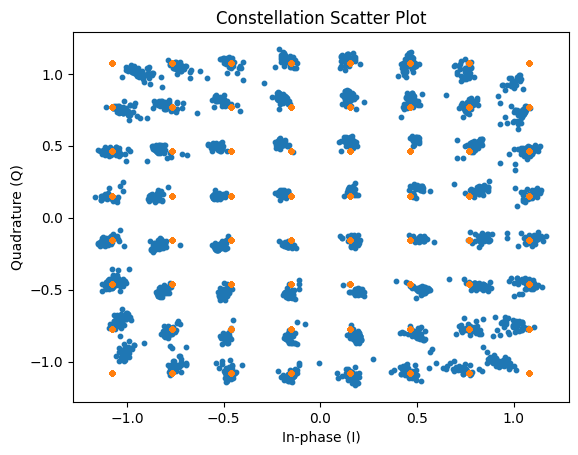

In [18]:
model = EndToEndSystem(N, constellation, snr_db, batch_size, stream_size, Pin, use_upsampling_filtering=True, with_dpd=True)
loss, x_mod_values, y_values, pa_out_values, filter_out = model()
phase = tf.math.angle(tf.reduce_sum(x_mod_values * tf.math.conj(y_values)))
# print(phase)
y_values = y_values * tf.exp(-1j * tf.cast(-phase, tf.complex64))
# y_norm = y_values * tf.exp(-1j * tf.cast(phase, tf.complex64))
# y_norm = y_values/tf.complex(tf.reduce_sum(tf.abs(y_values)),0.0)
y_norm = y_values/tf.complex(tf.sqrt(tf.reduce_mean(tf.abs(y_values)**2)),0.0)
# x_mod_values = x_mod_values/tf.complex(tf.reduce_sum(tf.abs(x_mod_values)),0.0)
x_mod_values = x_mod_values/tf.complex(tf.sqrt(tf.reduce_mean(tf.abs(x_mod_values)**2)),0.0)
# print(loss)

plt.figure()
plt.scatter(tf.math.real(y_norm), tf.math.imag(y_norm), s=10)
plt.scatter(tf.math.real(x_mod_values), tf.math.imag(x_mod_values), s=10)
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.title("Constellation Scatter Plot")
plt.show()

In [23]:
print(tf.reduce_sum(tf.abs(y_values)))

tf.Tensor(163973.25, shape=(), dtype=float32)


In [16]:
print(tf.reduce_mean(tf.abs(y_values)**2))

tf.Tensor(4693.3647, shape=(), dtype=float32)


In [12]:
tf.reduce_sum(tf.abs(x_mod_values)).numpy()

0.9999999

In [19]:
print(tf.reduce_mean(tf.abs(x_mod_values)**2))

tf.Tensor(0.98173845, shape=(), dtype=float32)


In [13]:
y_values.shape

TensorShape([10, 256])

In [14]:
x_mod_values.shape

TensorShape([10, 256])

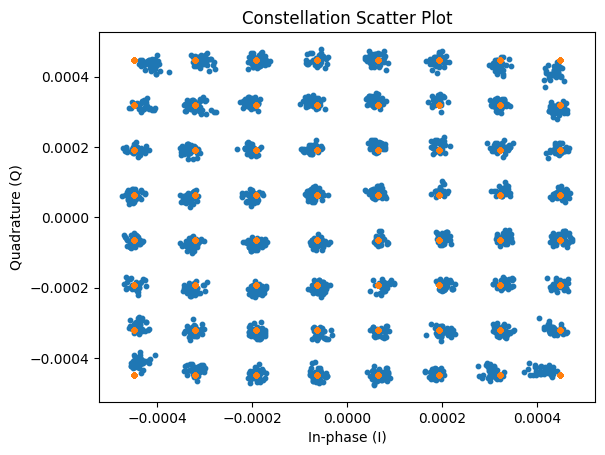

In [102]:
model = EndToEndSystem(N, constellation, snr_db, batch_size, stream_size, use_upsampling_filtering=True, with_dpd=False)
loss, x_mod_values, y_values, pa_out_values, filter_out = model()
phase = tf.math.angle(tf.reduce_sum(x_mod_values * tf.math.conj(y_values)))
# print(phase)
y_values = y_values * tf.exp(-1j * tf.cast(-phase, tf.complex64))
# y_norm = y_values * tf.exp(-1j * tf.cast(phase, tf.complex64))
y_norm = y_values/tf.complex(tf.reduce_sum(tf.abs(y_values)),0.0)
x_mod_values = x_mod_values/tf.complex(tf.reduce_sum(tf.abs(x_mod_values)),0.0)
# print(loss)

plt.figure()
plt.scatter(tf.math.real(y_norm), tf.math.imag(y_norm), s=10)
plt.scatter(tf.math.real(x_mod_values), tf.math.imag(x_mod_values), s=10)
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.title("Constellation Scatter Plot")
plt.show()


### Quantifying ACPR

In [106]:
class ACPRCalculatorTF:
    """TensorFlow implementation of Adjacent Channel Power Ratio calculation"""

    def __init__(self):
        pass

    def welch_tf(self, x, fs, nperseg=512, noverlap=0):
        """
        Stable Welch PSD using TensorFlow FFT.
        Produces two-sided PSD like SciPy (return_onesided=False).
        """

        # Ensure tensor & complex type
        if not isinstance(x, tf.Tensor):
            x = tf.convert_to_tensor(x)
        x = tf.cast(tf.reshape(x, [-1]), tf.complex64)

        win = tf.signal.hann_window(
            nperseg, periodic=True, dtype=tf.float32
        )
        hop = nperseg - noverlap

        # --- Zero-pad if too short (SciPy behavior) ---
        x_len = tf.shape(x)[0]
        x = tf.cond(
            x_len < nperseg,
            lambda: tf.concat(
                [x, tf.zeros(nperseg - x_len, dtype=x.dtype)], axis=0
            ),
            lambda: x
        )

        # --- Frame the signal like Welch ---
        frames = tf.signal.frame(
            x,
            frame_length=nperseg,
            frame_step=hop
        )  # shape [num_frames, nperseg]

        # Apply window
        frames = frames * tf.cast(win, tf.complex64)

        # --- FFT each frame ---
        X = tf.signal.fft(frames)

        # Power spectral density per frame
        win_power = tf.reduce_sum(win**2)
        Pxx = (tf.abs(X)**2) / (fs * win_power)

        # Average across segments
        Pxx_mean = tf.reduce_mean(Pxx, axis=0)

        # Two-sided frequency vector (matches SciPy)
        freqs = tf.range(
            -nperseg // 2,
            nperseg // 2,
            dtype=tf.float32
        ) * (fs / nperseg)

        Pxx_mean = tf.signal.fftshift(Pxx_mean)


        return freqs, Pxx_mean

    def calculate_acpr_sur(
        self,
        signal,
        fs,
        f0_bb,
        meas_bw_main,
        acpr_offsets,
        meas_bw_acpr
    ):

        f, Pxx = self.welch_tf(
            signal, fs, nperseg=512, noverlap=0
        )
        Pxx_lin = tf.abs(Pxx)

        def band_power(f, Pxx, f_center, BW):
            mask = tf.logical_and(
                f >= f_center - BW / 2,
                f <= f_center + BW / 2
            )
            df = f[1] - f[0]
            return tf.reduce_sum(tf.boolean_mask(Pxx, mask)) * tf.abs(df)

        Pmain = band_power(f, Pxx_lin, f0_bb, meas_bw_main)

        ChP = 10.0 * tf.math.log(Pmain + 1e-30) / tf.math.log(10.0)

        Pacp_lower = band_power(
            f, Pxx_lin, f0_bb - acpr_offsets[0], meas_bw_acpr
        )
        Pacp_upper = band_power(
            f, Pxx_lin, f0_bb + acpr_offsets[0], meas_bw_acpr
        )
        print(Pacp_upper+Pmain+Pacp_lower)
        acpr1 = 10.0 * tf.math.log(Pacp_lower / Pmain + 1e-30) / tf.math.log(10.0)
        acpr2 = 10.0 * tf.math.log(Pacp_upper / Pmain + 1e-30) / tf.math.log(10.0)

        return acpr1, acpr2, ChP


In [107]:
acpr_obj = ACPRCalculatorTF()
fs_input = 400000000.0 # This is Symbol_rate * Upsample factor
f0_bb_input = 0.0
meas_bw_main_input = 100000000.0 # This is Symbol_rate
acpr_offsets_input = [100000000.0*(1+0.3)*0.9] # 0.3 is the roll-off factor
meas_bw_acpr_input = 100000000.0 # This is Symbol_rate

In [111]:
model = EndToEndSystem(N, constellation, snr_db, batch_size, stream_size, use_upsampling_filtering=True, with_dpd=True)
loss, x_mod_values, y_values, pa_out_values, filter_out = model()
filterout_rms = np.sqrt(tf.reduce_mean(tf.square(tf.abs(filter_out))).numpy())

f_plot, Pxx_plot = acpr_obj.welch_tf(
    pa_out_values*107.33, fs_input, nperseg=512, noverlap=0  # print(filter_out.shape) (10, 1152) sqrt(10*1152) = 107.33
)
f_plot, Pxx_filter_out = acpr_obj.welch_tf(
    filter_out*107.33/filterout_rms, fs_input, nperseg=512, noverlap=0
)

print('With DPD ACPR:')
acpr1_val, acpr2_val, ChP_val = acpr_obj.calculate_acpr_sur(pa_out_values,fs_input,f0_bb_input,meas_bw_main_input,acpr_offsets_input,meas_bw_acpr_input)
print('ACPR 1:',acpr1_val.numpy(),'ACPR 2:', acpr2_val.numpy(),'ChP:', ChP_val.numpy())

With DPD ACPR:
tf.Tensor(1009.5905, shape=(), dtype=float32)
ACPR 1: -46.489086 ACPR 2: -48.131126 ChP: 30.041288


tf.Tensor(1051.4601, shape=(), dtype=float32)
tf.Tensor(-34.7442, shape=(), dtype=float32) tf.Tensor(-35.02477, shape=(), dtype=float32) tf.Tensor(30.215105, shape=(), dtype=float32)


In [112]:
model = EndToEndSystem(N, constellation, snr_db, batch_size, stream_size, use_upsampling_filtering=True, with_dpd=False)
loss, x_mod_values, y_values, pa_out_values, filter_out = model()

f_plot, Pxx_w_dpd_out = acpr_obj.welch_tf(
    pa_out_values*107.33, fs_input, nperseg=512, noverlap=0
)
print('Without DPD ACPR:')
acpr1_val, acpr2_val, ChP_val = acpr_obj.calculate_acpr_sur(pa_out_values,fs_input,f0_bb_input,meas_bw_main_input,acpr_offsets_input,meas_bw_acpr_input)
print('ACPR 1:',acpr1_val.numpy(),'ACPR 2:', acpr2_val.numpy(),'ChP:', ChP_val.numpy())

Without DPD ACPR:
tf.Tensor(1035.1326, shape=(), dtype=float32)
ACPR 1: -34.96252 ACPR 2: -34.87498 ChP: 30.147161


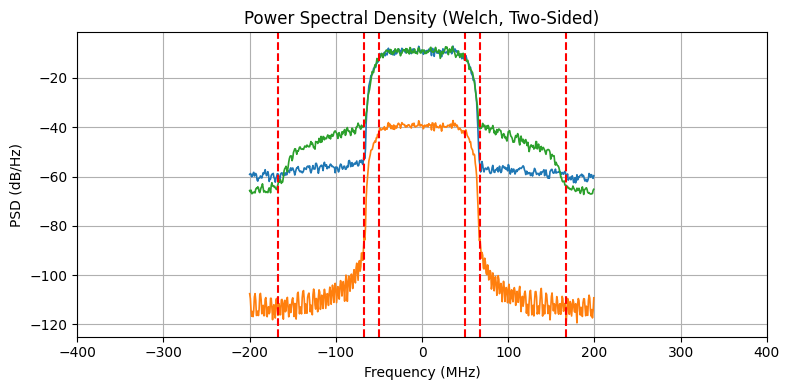

In [110]:
# Convert TensorFlow tensors → NumPy
f = f_plot.numpy()
Pxx = Pxx_plot.numpy()
Pxx_filter = Pxx_filter_out.numpy()
Pxx_w_dpd = Pxx_w_dpd_out.numpy()
# Convert to dB/Hz
Pxx_dB = 10 * np.log10(np.abs(Pxx) + 1e-30)
Pxx_filter_dB = 10 * np.log10(np.abs(Pxx_filter) + 1e-30)
Pxx_w_dpd_dB = 10 * np.log10(np.abs(Pxx_w_dpd) + 1e-30)

plt.figure(figsize=(8, 4))
plt.plot(f / 1e6, Pxx_dB, linewidth=1.2)
plt.plot(f / 1e6, Pxx_filter_dB, linewidth=1.2)
plt.plot(f / 1e6, Pxx_w_dpd_dB, linewidth=1.2)

plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dB/Hz)")
plt.xlim([-400,400])
plt.title("Power Spectral Density (Welch, Two-Sided)")

plt.axvline(x=(acpr_offsets_input[0] - meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(acpr_offsets_input[0] + meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")

plt.axvline(x=(-acpr_offsets_input[0] - meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(-acpr_offsets_input[0] + meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")

plt.axvline(x=(- meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.grid(True)

plt.tight_layout()
plt.show()